In [1]:
!pip install eli5

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import sys
!{sys.executable} -m pip install eli5

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import sys
print(sys.executable)
!pip --version

C:\ProgramData\anaconda3\python.exe
pip 25.1.1 from C:\Users\vatha\AppData\Roaming\Python\Python313\site-packages\pip (python 3.13)



Columns in dataset:
Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')

Unique values in churn column 'Customer Status':
['Stayed' 'Churned' 'Joined']
0      NaN
1      NaN
5      NaN
6      NaN
7      NaN
        ..
7035   NaN
7038   NaN
7040   NaN
7041   NaN

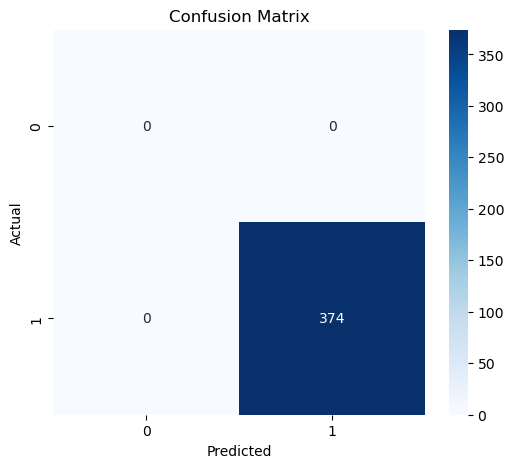


Customer segments count:
Segment
At Risk    1869
Name: count, dtype: int64


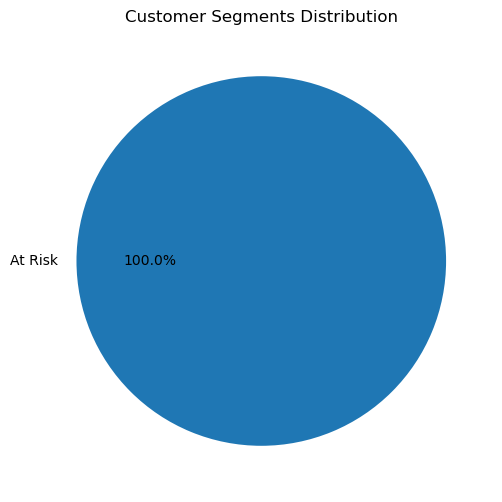

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df = pd.read_csv('telecom_customer_churn.csv')

print("Columns in dataset:")
print(df.columns)

churn_col = 'Customer Status'  

print(f"\nUnique values in churn column '{churn_col}':")
print(df[churn_col].unique())

churn_map = {
    'Active': 0,
    'Churned': 1,
    'Exited': 1,
    'Inactive': 1,
}

df[churn_col] = df[churn_col].map(churn_map)

if df[churn_col].isna().sum() > 0:
    print(f"Warning: There are unmapped values in churn column. Rows with NaN target will be dropped.")
    print(df.loc[df[churn_col].isna(), churn_col])
    df = df.dropna(subset=[churn_col])

if 'Customer ID' in df.columns:
    df.drop(['Customer ID'], axis=1, inplace=True)

if 'Total Charges' in df.columns:
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
    median_val = df['Total Charges'].median()
    df['Total Charges'] = df['Total Charges'].fillna(median_val)

for col in df.columns:
    if df[col].dtype == 'object' and col != churn_col:
        if df[col].nunique() == 2:
            df[col] = LabelEncoder().fit_transform(df[col])
        else:
            df = pd.get_dummies(df, columns=[col])

X = df.drop(columns=[churn_col])
y = df[churn_col]

print(f"Number of NaNs in target (y): {y.isna().sum()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

df['Predicted_Churn'] = model.predict(X)

def segment(row):
    tenure_col = 'Tenure in Months'
    if row['Predicted_Churn'] == 1:
        return 'At Risk'
    elif tenure_col in df.columns and row[tenure_col] > 30:
        return 'Loyal'
    else:
        return 'Dormant'

df['Segment'] = df.apply(segment, axis=1)

print("\nCustomer segments count:")
print(df['Segment'].value_counts())

plt.figure(figsize=(6,6))
df['Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Customer Segments Distribution")
plt.ylabel('')
plt.show()


In [15]:
print(df['Customer Status'].unique())


[1.]


In [21]:
print(df.isnull().sum())

Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
Zip Code                                0
                                       ..
Churn Reason_Price too high             0
Churn Reason_Product dissatisfaction    0
Churn Reason_Service dissatisfaction    0
Predicted_Churn                         0
Segment                                 0
Length: 848, dtype: int64


In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
  'n_estimators': [100, 200],
  'max_depth': [None, 10, 20],
  'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


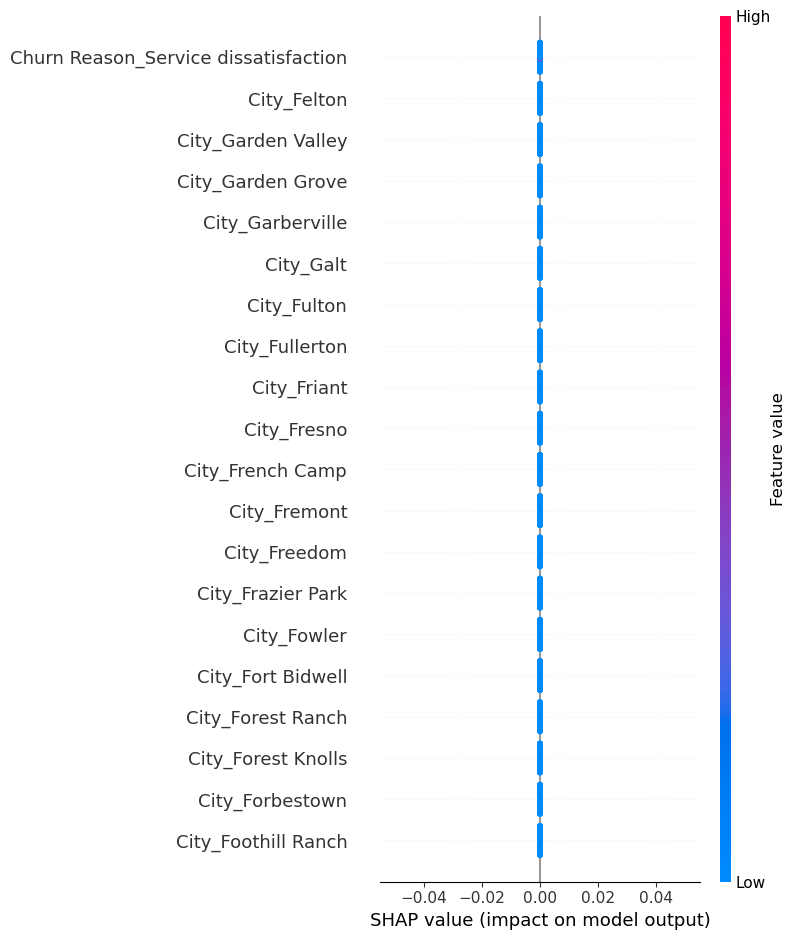

In [26]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [43]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('mydatabase.db')

conn.execute('''CREATE TABLE IF NOT EXISTS customers (
                    CustomerID TEXT,
                    TotalCharges REAL,
                    Tenure INTEGER,
                    Contract TEXT,
                    PaymentMethod TEXT
                )''')

query = """
SELECT CustomerID, TotalCharges / NULLIF(Tenure, 0) AS AvgChargesPerMonth, Contract, PaymentMethod
FROM customers
"""

df = pd.read_sql_query(query, conn)
print(df)

conn.close()


Empty DataFrame
Columns: [CustomerID, AvgChargesPerMonth, Contract, PaymentMethod]
Index: []


In [1]:
def preprocess_data(df):
    df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].median())
    df['AvgChargesPerMonth'] = df['Total Charges'] / df['Tenure'].replace(0, 1)

    df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod'], drop_first=True)
    return df


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [37]:
print("Train class distribution:")
print(y_train.value_counts())

print("Test class distribution:")
print(y_test.value_counts())


Train class distribution:
Customer Status
1.0    1495
Name: count, dtype: int64
Test class distribution:
Customer Status
1.0    374
Name: count, dtype: int64


In [39]:
from sklearn.metrics import confusion_matrix

labels = [0, 1]  
print(confusion_matrix(y_test, y_pred, labels=labels))


[[  0   0]
 [  0 374]]
